# Shapley Values - Credit Default Prediction on Amex Dataset

### Importing the necessary libraries

In [1]:
import numpy as np
import pandas as pd 

import pyspark
from pyspark import StorageLevel
from pyspark.sql import (
    SparkSession, 
    types, 
    functions as F,
)
from pyspark.sql.functions import (
    col,
    isnan,
    when,
    count,
)
from pyspark.ml import Pipeline 
from pyspark.ml.feature import (
    OneHotEncoder, 
    StringIndexer, 
    VectorAssembler, 
    Imputer,
)
from pyspark.ml.classification import (
    LogisticRegression, 
    LinearSVC,
    DecisionTreeClassifier,
    GBTClassifier,
    RandomForestClassifier,
)
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import shap

import itertools

import pickle

### Create a Spark Session

In [2]:
spark = SparkSession.builder \
                    .appName("amex-app") \
                    .master("local[*]") \
                    .getOrCreate()

### Important Local Variables

In [3]:
TRAIN_DATA_PATH = 'gs://icdp-bigdata-bucket/train_data.csv'
TRAIN_LABEL_PATH = 'gs://icdp-bigdata-bucket/train_labels.csv'

### Miscellaneous Utility Functions

In [4]:
## Function to create a Schema Object for the Dataframe 
def create_spark_schema(series):
    fields = list()
    
    for value in series: 
        if value in string_dtypes:
            fields.append(
                types.StructField(
                    value, 
                    types.StringType(), 
                    True,
                )
            )
        elif value in date_dtypes:
            fields.append(
                types.StructField(
                    value, 
                    types.DateType(), 
                    True,
                )
            )
        elif value in integer_dtypes:
            fields.append(
                types.StructField(
                    value, 
                    types.IntegerType(), 
                    True,
                )
            )
        else:
            fields.append(
                types.StructField(
                    value, 
                    types.FloatType(), 
                    True,
                )
            )
    return types.StructType(fields)

In [5]:
#Add Suffix to List Elements
def add_suffix(names, suffix):
    return [name + suffix for name in names]

In [6]:
# Drop Columns with Null values above a certain threshold
def dropNullColumns(df, threshold):
    """
    This function drops columns containing all null values.
    :param df: A PySpark DataFrame
    """
  
    null_counts = df.select([F.count(F.when(F.col(c).isNull(), c)).alias(
        c) for c in df.columns]).collect()[0].asDict()
    print("null counts calculated...")
    df_count = df.count()
    col_to_drop = [k for k, v in null_counts.items() if v >(df_count * threshold)]  
    print("columns to drop found...")
    df = df.drop(*col_to_drop)  
  
    return df, col_to_drop

### Reading the Dataframe

#### Reading the First 20 rows only

In [7]:
train_df_temp = spark.read.option(
    "header", 'true',
).csv(
    TRAIN_DATA_PATH,
).limit(
    20
)
train_labels_temp = spark.read.option(
    "header", 'true',
).csv(
    TRAIN_LABEL_PATH,
).limit(
    20
)

#### Define Schema Using Sampled Temporary Dataframe

In [8]:
## Known Datatypes: 

string_dtypes = ["customer_ID", 'B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
date_dtypes = ['S_2']
integer_dtypes = ['target']

In [9]:
train_schema = create_spark_schema(train_df_temp.columns)
label_schema = create_spark_schema(train_labels_temp.columns)

#### Remove Temp Datasets from Memory

In [10]:
train_df_temp.unpersist()
train_labels_temp.unpersist()

del train_df_temp
del train_labels_temp

#### Reading the Whole Dataset with the Inferred Schema

In [11]:
train_df = spark.read.option(
    "header", 
    "true",
).csv(
    TRAIN_DATA_PATH, 
    schema=train_schema
)
label_df = spark.read.option(
    "header", 
    "true",
).csv(
    TRAIN_LABEL_PATH, 
    schema=label_schema,
)

In [12]:
## Other categorization of the known dtypes
info_cols = ['customer_ID', 'S_2']
target_cols = ['target']
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']


# Define Numeric Columns
excluded = info_cols + cat_cols
num_cols = [col for col in train_df.columns if col not in excluded]

### Preprocessing of the Dataset

#### Dropping Null Columns

In [13]:
## Remove All Columns with More than 5% Missing Values
train_df, cols_to_drop = dropNullColumns(train_df, 0.05)

22/12/23 22:08:50 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


null counts calculated...


columns to drop found...


#### Remove Less Important Column S_2

In [14]:
## Remove the S_2 variable as the testing data and the training data are in different time periods 
train_df = train_df.drop("S_2")

In [15]:
cols_to_drop.append("S_2")

#### Converting Categorical Columns to Numeric using StringIndexer

In [16]:
cat_columns_to_index = list(set(train_df.columns) & set(cat_cols))

In [17]:
cat_cols_indexed = add_suffix(cat_columns_to_index, "_index")

## Create StringIndexer Object
indexer = StringIndexer(
    inputCols=cat_columns_to_index,
    outputCols=cat_cols_indexed,
)
indexer.setHandleInvalid("keep")
indexer_model = indexer.fit(train_df)

train_df = indexer_model.transform(train_df)

#### Impute values for numerical columns

In [18]:
num_columns_to_impute = list(set(train_df.columns) & set(num_cols))

In [19]:
num_cols_imputed = add_suffix(num_columns_to_impute, "_imputed")

##Create Imputer
imputer = Imputer(
    inputCols=num_columns_to_impute,
    outputCols=num_cols_imputed,
)
imputer.setStrategy("median")

imputer_model = imputer.fit(train_df)

train_df = imputer_model.transform(train_df)

### Shapley Values Extraction

In [20]:
cols_to_use = ["customer_ID"] + num_cols_imputed + cat_cols_indexed
cols_to_use

['customer_ID',
 'B_20_imputed',
 'B_19_imputed',
 'S_8_imputed',
 'R_2_imputed',
 'R_5_imputed',
 'R_23_imputed',
 'D_118_imputed',
 'D_69_imputed',
 'D_80_imputed',
 'D_51_imputed',
 'D_84_imputed',
 'B_6_imputed',
 'S_12_imputed',
 'D_83_imputed',
 'B_41_imputed',
 'R_3_imputed',
 'D_71_imputed',
 'R_11_imputed',
 'D_145_imputed',
 'D_92_imputed',
 'D_107_imputed',
 'D_94_imputed',
 'R_27_imputed',
 'D_121_imputed',
 'D_139_imputed',
 'D_141_imputed',
 'D_125_imputed',
 'R_14_imputed',
 'D_59_imputed',
 'S_25_imputed',
 'D_104_imputed',
 'D_39_imputed',
 'B_22_imputed',
 'D_52_imputed',
 'B_16_imputed',
 'D_41_imputed',
 'D_75_imputed',
 'B_31_imputed',
 'R_6_imputed',
 'B_25_imputed',
 'D_55_imputed',
 'B_11_imputed',
 'R_28_imputed',
 'R_21_imputed',
 'R_8_imputed',
 'B_10_imputed',
 'S_23_imputed',
 'R_25_imputed',
 'D_124_imputed',
 'R_16_imputed',
 'D_65_imputed',
 'B_36_imputed',
 'R_17_imputed',
 'D_113_imputed',
 'D_129_imputed',
 'D_130_imputed',
 'R_13_imputed',
 'B_24_imp

#### Convert Dataframe to Pandas 

In [21]:
train_pf = train_df.select(*cols_to_use).limit(100000).toPandas()

In [22]:
train_pf = pd.get_dummies(train_pf, columns = cat_cols_indexed, drop_first=True)

In [23]:
label_pf = pd.read_csv(TRAIN_LABEL_PATH)

#### Merge Two Dataframe based on ```customer_ID```

In [24]:
mergedRes = pd.merge(train_pf, label_pf, on ='customer_ID')

#### Train Test Split the Data

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    mergedRes.drop(["customer_ID", "target"],axis=1), mergedRes["target"], test_size=0.50, random_state=101
)

#### Fit LogisticRegression Model

In [26]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression()

In [27]:
predictions = logmodel.predict(X_test)

In [28]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     37229
           1       0.77      0.71      0.74     12771

    accuracy                           0.87     50000
   macro avg       0.83      0.82      0.83     50000
weighted avg       0.87      0.87      0.87     50000



#### Get Shap Explainer and Shap Values

In [29]:
explainer = shap.Explainer(logmodel, X_train, feature_names=train_pf.columns)
shap_values = explainer(X_test)

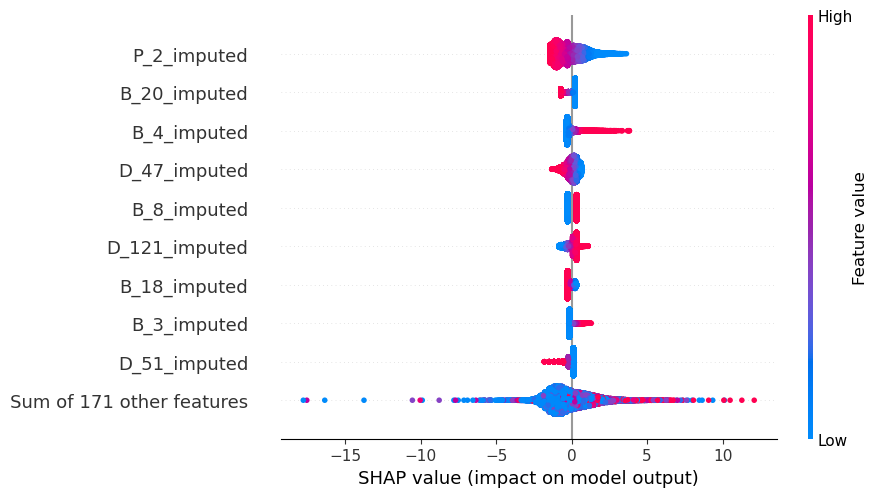

In [30]:
shap.plots.beeswarm(shap_values)

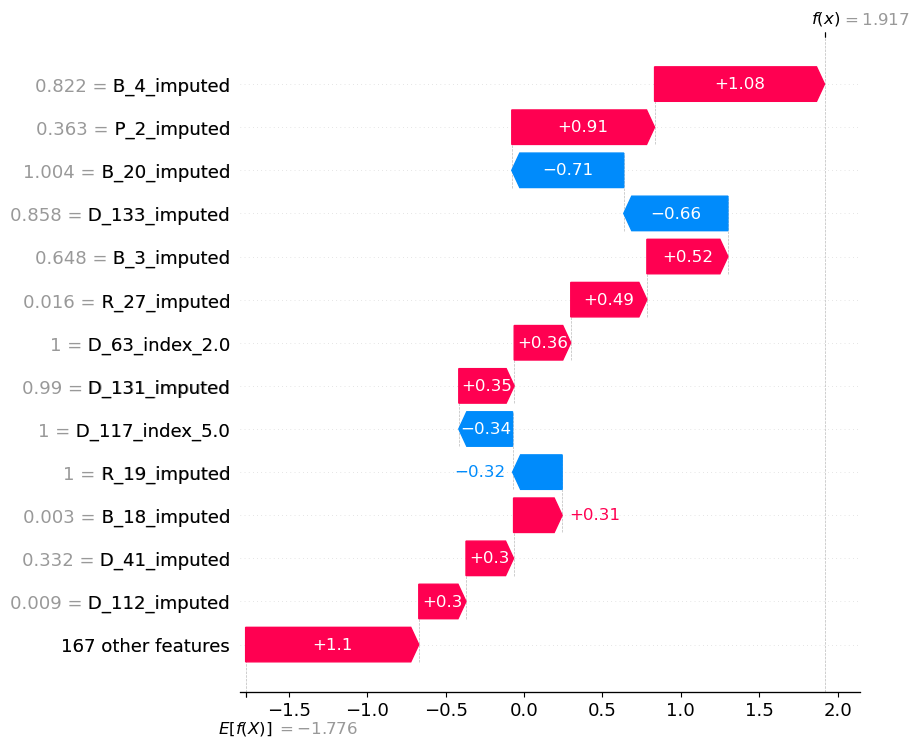

In [31]:
shap.plots.waterfall(shap_values[10], max_display=14)

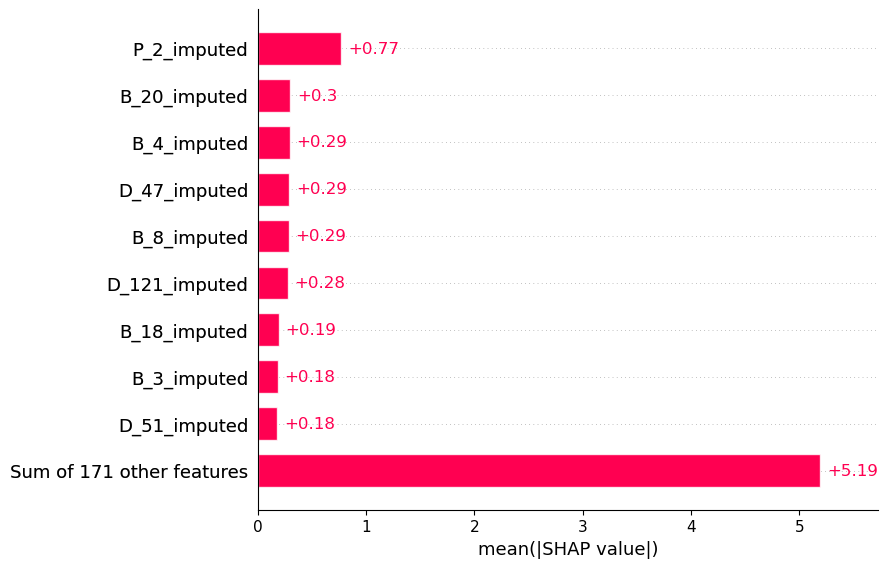

In [32]:
shap.plots.bar(shap_values)

#### Saving the Explainer Object and the Shap  Values

In [ ]:
with open('/home/aap2239/202212-30-Explainable-Credit-Default-Prediction/assets/shap/shap_exp.pkl', 'wb') as handle:
    pickle.dump(explainer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/home/aap2239/202212-30-Explainable-Credit-Default-Prediction/assets/shap/shap_values.pkl', 'wb') as handle:
    pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)